##### Hello everyone,

##### Welcome to this place.

This notebook is a really simple baseline of Deep Learning on Sentiment Analysis. In this notebook I'll show you a simple preprocessing and a simple neural net using Convolutional layers (CNN).

In my previous notebook about Deep Learning on Sentiment (here: https://lnkd.in/d6zSWYV ) I've showed you how to build an LSTM neural net. The goal of this notebook is produce an evidence about Convolutional layers applied to NLP problems.

It means that I would like to predict the sentiment of feedbacks of movies using convolutional layers. The label we have is "0" for bad movies (mark < 5 IMDB) and "1" for good movies (mark > 7 IMDB)

##### STRATEGY:

In this notebook i'm going to:

    1) load data
    2) clean data
    3) train word2vec ad hoc
    4) creat extra-variable
    5) train model
    
In a previous notebook I've showed a really simple introduction to word2vec. If you want to check what I've previously done or if you just need a reminder about word2vec you can find that example here: https://lnkd.in/dddZpKt

###### If you have already watched the preprocessing of the old notebook about LSTM you can skip until the model

In [2]:
import pandas as pd
import re
import time 
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re

In [12]:
from gensim.models import word2vec, KeyedVectors, Word2Vec

In [5]:
data = pd.read_csv("prova.tsv", header=0, delimiter="\t", quoting=3)
data.review[0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [6]:
eng_stop = nltk.corpus.stopwords.words('english')

def nostop(text, stops):
    pattern = re.compile(r'\b(' + r'|'.join(stops) + r')\b\s*')
    text = pattern.sub(' ', text)
    text = re.sub(" +", " ", text).strip()
    return(text)

def fast_clean(x):
    out = re.sub('[^A-Za-z0-9]+', ' ', x)
    out = out.lower()
    return(out)

In [8]:
data['review_clean_nostop'] = data.apply(axis=1, func = lambda x: nostop(fast_clean(x.review),eng_stop))
data['review_clean_nostop'][0]

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay br br visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice br br actual feature film bit finally starts 20 minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music br br lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually 

In [14]:
corpus_nltk = [i for i in data['review_clean_nostop']]

corpus_nltk = " ".join(corpus_nltk)
token_nltk = nltk.word_tokenize(corpus_nltk)

freqd_nltk = nltk.FreqDist(token_nltk)
freqd_nltk_L = dict((k, v) for k, v in freqd_nltk.items() if v == 1)
dropL = list(freqd_nltk_L.keys())

In [15]:
x = time.time()
data['review_clean_nostop_droplow'] = data.apply(axis=1, func = lambda x: nostop(x.review_clean_nostop,dropL))
print('I worked for ' + str(round((time.time()-x)/60,2)) + ' minutes')

I worked for 12.44 minutes


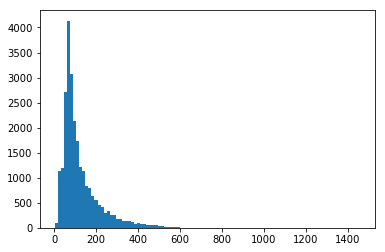

count    25000.000000
mean       125.097840
std         94.649944
min          4.000000
25%         66.000000
50%         93.000000
75%        153.000000
max       1455.000000
Name: len, dtype: float64

In [16]:
data['len'] = data.apply(axis=1, func = lambda x: len(x.review_clean_nostop.split()))
plt.hist(data['len'], bins=100)
plt.show()
data['len'].describe()

In [17]:
data = data.sample(frac=1)

In [18]:
test = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)
unlabeled = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)

In [19]:
test['review_clean_nostop'] = test.apply(axis=1, func = lambda x: nostop(fast_clean(x.review),eng_stop))
unlabeled['review_clean_nostop'] = unlabeled.apply(axis=1, func = lambda x: nostop(fast_clean(x.review),eng_stop))

In [20]:
x = time.time()
test['review_clean_nostop_droplow'] = test.apply(axis=1, func = lambda x: nostop(x.review_clean_nostop,dropL))
unlabeled['review_clean_nostop_droplow'] = unlabeled.apply(axis=1, func = lambda x: nostop(x.review_clean_nostop,dropL))
print('I worked for ' + str(round((time.time()-x)/60,2)) + ' minutes')

I worked for 36.71 minutes


In [21]:
def build_corpus(data, x):
    corpus = []
    for sentence in data[x].iteritems():
        word_list = sentence[1].split()
        corpus.append(word_list)

    return corpus

corpus = build_corpus(data, 'review_clean_nostop_droplow')

In [22]:
corpus_test = build_corpus(test, 'review_clean_nostop_droplow')
corpus_unlabeled = build_corpus(unlabeled, 'review_clean_nostop_droplow')

In [23]:
corpus_all = corpus + corpus_test + corpus_unlabeled

In [24]:
x = time.time()
n_dim = 50
model2vec = word2vec.Word2Vec(corpus_all, size=n_dim, window=5, min_count=5, workers=4)
print('I worked for ' + str(round((time.time()-x)/60,2)) + ' minutes')

I worked for 0.59 minutes


In [35]:
def count_word(x,posne):
    app = x.split()
    count = 0
    for i in app:
        if i in posne:
            count += 1
    return(count)

In [36]:
pos = open('positive.txt', 'r', encoding='latin1').readlines()
pos = "".join(pos).split("\n")

neg = open('negative.txt', 'r', encoding='latin1').readlines()
neg = "".join(neg).split("\n")

In [38]:
x = time.time()

data['positive'] = data.apply(axis=1, func = lambda x: count_word(x.review_clean_nostop_droplow, pos))
data['negative'] = data.apply(axis=1, func = lambda x: count_word(x.review_clean_nostop_droplow, neg))

data['positive_ratio'] = data['positive']/data['len']
data['negative_ratio'] = data['negative']/data['len']

data['special_char'] = data.apply(axis=1, func = lambda x: len(re.findall("\.|\:|\;|\,|\(|\)|\[|\]|\&|\'|\"|\-|\_|\°|\{|\}|\+\*\#\@\/",x.review)))
data['esclamation_mark'] = data.apply(axis=1, func = lambda x: len(re.findall("\!",x.review)))
data['question_mark'] = data.apply(axis=1, func = lambda x: len(re.findall("\?",x.review)))

print('I worked for ' + str(round((time.time()-x)/60,2)) + ' minutes')

I worked for 4.97 minutes


In [ ]:
# model2vec.save('w2v_movies_sentiment')
# data.to_csv('data_sentiment_movies.csv')

In [16]:
model2vec = Word2Vec.load('w2v_movies_sentiment')
data = pd.read_csv('data_sentiment_movies.csv')

## Let's play with KERAS!

Keras is a cool neural network API written in Python. You can find all the documentation you need here: https://keras.io/#you-have-just-found-keras

If you are confortable with math and you want to go deep you can find the introduction to CNN here:
http://yann.lecun.com/exdb/publis/pdf/lecun-99.pdf

Or a good easy explanation about CNN on NLP: 
http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/

In [33]:
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Input, BatchNormalization, ZeroPadding1D, GlobalAveragePooling1D
from keras.layers import Embedding, Conv1D, concatenate
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [6]:
input_len = 200

In [7]:
%%time
texts = list(data.review.values)

tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(texts)

sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

data_1 = pad_sequences(sequences, maxlen=input_len)
pred = np.array(data.sentiment.values)
print('Shape of data tensor:', data_1.shape)
print('Shape of label tensor:', pred.shape)

Found 87173 unique tokens
Shape of data tensor: (25000, 200)
Shape of label tensor: (25000,)
CPU times: user 6.85 s, sys: 76 ms, total: 6.93 s
Wall time: 6.88 s


In [8]:
n_dim = 50

In [17]:
nb_words = min(200000, len(word_index))+1

embedding_matrix = np.zeros((nb_words, n_dim))
for word, i in word_index.items():
    if word in model2vec.wv.vocab:
        embedding_matrix[i] = model2vec.wv[word]

In [56]:
model_input = Input(shape=(input_len,))

model = Embedding(nb_words, n_dim, weights=[embedding_matrix],input_length=input_len,
        trainable=False)(model_input)

model = Dropout(0.25)(model)

C1 = Conv1D(filters=128, kernel_size=1, padding='valid', activation='relu')
C2 = Conv1D(filters=128, kernel_size=2, padding='valid', activation='relu')
C3 = Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu')
C4 = Conv1D(filters=128, kernel_size=4, padding='valid', activation='relu')

C1 = C1(model)
C2 = C2(model)
C3 = C3(model)
C4 = C4(model)

GP1 = GlobalAveragePooling1D()(C1)
GP2 = GlobalAveragePooling1D()(C2)
GP3 = GlobalAveragePooling1D()(C3)
GP4 = GlobalAveragePooling1D()(C4)

model = concatenate([GP1, GP2, GP3, GP4])

model = Dropout(0.25)(model)
model = Dense(512)(model)
model = Activation('relu')(model)
model = BatchNormalization()(model)

model_input2 = Input(shape=(8,))

model2 = Dropout(0.25)(model_input2)
model2 = Dense(32, activation='relu')(model2)
model2 = BatchNormalization()(model2)

model = concatenate([model, model2])

model = Dropout(0.25)(model)
model = Dense(256)(model)
model = Activation('relu')(model)
model = BatchNormalization()(model)

model = Dropout(0.25)(model)
model = Dense(128)(model)
model = Activation('relu')(model)
model = BatchNormalization()(model)

model = Dense(1)(model)
out = Activation('sigmoid')(model)

opt = SGD(lr = 0.1, momentum = 0.9, nesterov=True)

model = Model(inputs=[model_input,model_input2], outputs=out)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_41 (InputLayer)            (None, 200)           0                                            
____________________________________________________________________________________________________
embedding_25 (Embedding)         (None, 200, 50)       4358700     input_41[0][0]                   
____________________________________________________________________________________________________
dropout_74 (Dropout)             (None, 200, 50)       0           embedding_25[0][0]               
____________________________________________________________________________________________________
conv1d_110 (Conv1D)              (None, 200, 128)      6528        dropout_74[0][0]                 
___________________________________________________________________________________________

In [39]:
extra_variable = ['positive','negative','positive_ratio','len','negative_ratio',
                    'special_char','esclamation_mark','question_mark']

In [57]:
model.fit([data_1[10000:],np.array(data[extra_variable][10000:])], pred[10000:],
          batch_size=256,
          epochs=200,
          verbose=1,
          validation_data=([data_1[:10000],np.array(data[extra_variable][:10000])],  pred[:10000]), 
          callbacks = [
                      EarlyStopping(monitor='val_loss',patience=10)
                      ,ReduceLROnPlateau(monitor='val_loss',patience=5,factor=0.3, min_lr=1e-6, verbose=1)
                        ])

Train on 15000 samples, validate on 10000 samples
Epoch 1/200
15000/15000 [==============================] - 3s - loss: 0.4523 - acc: 0.7891 - val_loss: 0.4951 - val_acc: 0.8383
Epoch 2/200
15000/15000 [==============================] - 2s - loss: 0.3756 - acc: 0.8381 - val_loss: 0.4140 - val_acc: 0.8542
Epoch 3/200
15000/15000 [==============================] - 2s - loss: 0.3659 - acc: 0.8421 - val_loss: 0.3948 - val_acc: 0.8501
Epoch 4/200
15000/15000 [==============================] - 2s - loss: 0.3572 - acc: 0.8448 - val_loss: 0.3680 - val_acc: 0.8436
Epoch 5/200
15000/15000 [==============================] - 2s - loss: 0.3541 - acc: 0.8493 - val_loss: 0.3334 - val_acc: 0.8636
Epoch 6/200
15000/15000 [==============================] - 2s - loss: 0.3463 - acc: 0.8485 - val_loss: 0.3205 - val_acc: 0.8613
Epoch 7/200
15000/15000 [==============================] - 2s - loss: 0.3424 - acc: 0.8527 - val_loss: 0.3220 - val_acc: 0.8615
Epoch 8/200
15000/15000 [=============================

I used unlabeledTrainData and TestData as corpus to train word2vec. In my experience it's ok. It doesn't generate overfitting. 

You can also decide to use the pre-trained model by Google (I've showed this model here: https://lnkd.in/dddZpKt). I preferred to train a new model because I preferred a lower-dimensional model. 

If you want to improve this notebook you have multiple ways:
   
Preprocessing:

    1) You can choose better lists of words for "positive" and "negative"
    2) You can cut by hand(!!!) some neutral most-common words. Be careful to not delete positive or negative words as "good","bad" or similar!
    3) You can create much more extra-variables
    4) You can train word2vec more efficiently by tuning some parameters

Model:

    You have a large amount of ways to do better. I'll show you some alternatives in the future.

###### ABOUT THE MODEL:

What I did was produce 4 different convolutions with different kernel size: from 1 until 4. That means I decided to keep in mind from mono-grams to four-grams. I tried also with 5 but I found overfitt.

I'll show you (again if you didn't open it before) http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/ a good explanation about CNN on NLP. In which you can find a really simple explanation of what I previosly said.

###### P.S. This notebook is just an example.

In this task there are several problems. Because of the length of the comments this task looks like a document classification. 

Because of that my personal advice is straightforward in this direction: http://aclweb.org/anthology/D15-1167

I'll really appreciate to be contacted for new points of view or advices as well as better solutions.

###### I hope you appreciate these examples. See you around,

###### Federico